In [2]:
from setup import *

# 1. Simulate FFPE samples using PCAWG mutation profiles

## 1.1 Read FFPE signatures

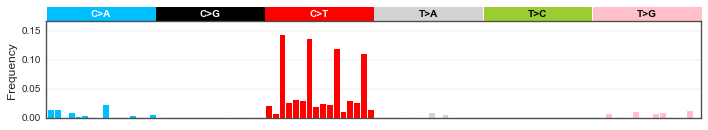

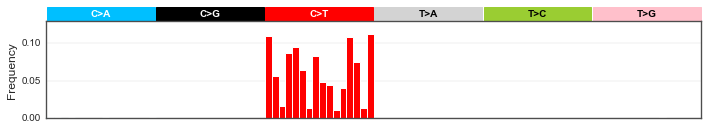

In [3]:
SBS96_plot(ffpe_sig_repaired, norm = True)
SBS96_plot(ffpe_sig_unrepaired, norm = True)

## 1.2 Read PCAWG data

PCAWG activity

In [4]:
activity = pd.read_csv("./Data/WGS_PCAWG.activities.csv")
activity.index = (activity['Cancer Types'] + "::" + activity['Sample Names']).values

SBS sig

In [5]:
SBS_sig = pd.read_csv("./Data/SBS_signatures.csv")
SBS_sig = SBS_sig.iloc[:, 2:].copy()

Mutational profiles

In [6]:
profiles = pd.read_csv("./Data/WGS_PCAWG.96.csv")
profile_values = profiles.iloc[:,2:]
profiles.head(2)

,Mutation type,Trinucleotide,Biliary-AdenoCA::SP117655,Biliary-AdenoCA::SP117556,Biliary-AdenoCA::SP117627,Biliary-AdenoCA::SP117775,Biliary-AdenoCA::SP117332,Biliary-AdenoCA::SP117712,Biliary-AdenoCA::SP117017,Biliary-AdenoCA::SP117031,...,Uterus-AdenoCA::SP94540,Uterus-AdenoCA::SP95222,Uterus-AdenoCA::SP89389,Uterus-AdenoCA::SP90503,Uterus-AdenoCA::SP92460,Uterus-AdenoCA::SP92931,Uterus-AdenoCA::SP91265,Uterus-AdenoCA::SP89909,Uterus-AdenoCA::SP90629,Uterus-AdenoCA::SP95550
0,C>A,ACA,269,114,105,217,52,192,54,196,...,117,233,94,114,257,139,404,97,250,170
1,C>A,ACC,148,56,71,123,36,139,54,102,...,90,167,59,64,268,75,255,78,188,137


## 1.3 Simulate PCAWG FFPE samples

In [7]:
def simulation(sample_indvidual, ffpe_sig, ffpe_load):
    ffpe_noise = poisson.rvs(ffpe_sig * ffpe_load)
    v = sample_indvidual + ffpe_noise
    return ([np.sum(ffpe_noise), v])

simulated_df_unrepaired_10_4, simulated_df_repaired_10_4 = pd.DataFrame(), pd.DataFrame()

unrepaired_noise_loads = []
repaired_noise_loads = []

for i, col in enumerate(profile_values.columns):
    npr.seed(i + 1)
    sample = profiles[col].to_numpy()
    noise_load, simulated_df_unrepaired_10_4 [col] = simulation(sample_indvidual = sample, 
                                                    ffpe_sig = ffpe_sig_unrepaired, 
                                                    ffpe_load = 10**4)
    
    unrepaired_noise_loads.append(noise_load)
    noise_load, simulated_df_repaired_10_4 [col] = simulation(sample_indvidual = sample, 
                                                    ffpe_sig = ffpe_sig_repaired, 
                                                    ffpe_load = 10**4)
    repaired_noise_loads.append(noise_load)
## write the simulated samples to Data folder
simulated_df_unrepaired_10_4.to_csv ("./Data/simulated_PCAWG_FFPE_unrepaired.csv", index = False)
simulated_df_repaired_10_4.to_csv ("./Data/simulated_PCAWG_FFPE_repaired.csv", index = False)

# 2. Correction of FFPE noise in the simulated samples
## 2.1 One example of correcting FFPE profile

We performed the same cleaning process for all simulated samples on the HPC (Apoctria, Queen Mary University of Longon) due to the long running time on local PC. Here we show an example on how it works and also correction result for one sample from colorectal cancer.

In [8]:
example_sample = "ColoRect-AdenoCA::SP21528"
cancer_type, sample_id =  example_sample.split("::")
biological_profile = profile_values[example_sample].to_numpy()
ffpe_profile = simulated_df_unrepaired_10_4[example_sample]

corrected_profile, corrected_profiles_df = correct_FFPE_profile(V = ffpe_profile.to_numpy(), 
                                                                W1 = ffpe_sig_unrepaired,
                                                                sample_id= sample_id)

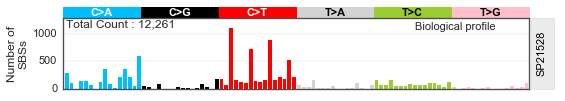

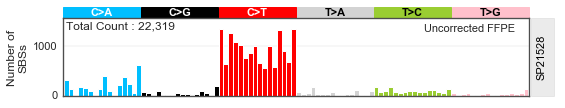

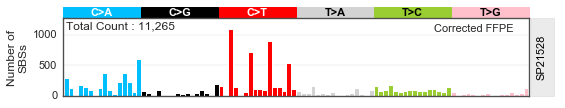

In [9]:
## plot all profiles
SBS96_plot(biological_profile, label = f"{sample_id}\n", 
           name = "Biological profile", file = "./Figures/Fig2a_1.pdf",
           height = 1.6, width = 8, s = 11)

SBS96_plot(ffpe_profile, label = f"{sample_id}\n", name = "Uncorrected FFPE",
           file = "./Figures/Fig2a_2.pdf",
           height = 1.7, width = 8, s = 11)

SBS96_plot(corrected_profile, label = f"{sample_id}\n", name = "Corrected FFPE",
           file = "./Figures/Fig2a_3.pdf",
           height = 1.7, width = 8, s = 11)

In [10]:
C2T_ind = ["C>T" == t for t in profiles['Mutation type']]
n_channel = np.sum(C2T_ind)
cs_C2T = cosine_similarity(biological_profile[C2T_ind].reshape(1,n_channel), 
                               corrected_profile[C2T_ind].reshape(1,n_channel))[0][0]
cs_all = cosine_similarity(biological_profile.reshape(1,96), 
                               corrected_profile.reshape(1,96))[0][0]
print ("Accuracy (C>T, 16-channel):", cs_C2T , "\t(96channel):", cs_all)

Accuracy (C>T, 16-channel): 0.988113187476812 	(96channel): 0.9914213947628656


**The impact of using corrected and uncorrected profiles on mutational process deconvolution in the given example**

In [11]:
df_example_act = pd.DataFrame()
channel_num = 96

active_sig_ind = activity.loc[example_sample][3:].values > 0 # select active signatures (>0) based on PCAWG activites data 
active_sig_num = np.sum(active_sig_ind)
act_sig =  SBS_sig.columns[active_sig_ind]
df_example_act['active_sig']= act_sig

npr.seed (12)    
## activities by uncorrected profile:
h, kl_loss = sig_refitting(V = ffpe_profile.to_numpy().reshape(channel_num, 1), 
                            W = SBS_sig.loc[:, active_sig_ind].to_numpy(), precision = 0.99)

df_example_act['Uncorrected activities'] = h.reshape(active_sig_num)/np.sum(h.reshape(active_sig_num))
    
## activities by corrected profile:
h, kl_loss = sig_refitting(V = corrected_profile.reshape(channel_num, 1), 
                               W = SBS_sig.loc[:, active_sig_ind].to_numpy(), precision = 0.99)
df_example_act['Corrected activities'] = h.reshape(active_sig_num)/np.sum(h.reshape(active_sig_num))
    
## True activities by biological profile:
h, kl_loss = sig_refitting(V = biological_profile.reshape(channel_num, 1), 
                               W = SBS_sig.loc[:, active_sig_ind].to_numpy(), precision = 0.99)
df_example_act['Biological activities'] = h.reshape(active_sig_num)/np.sum(h.reshape(active_sig_num))
df_example_act = df_example_act.set_index('active_sig')
df_example_act.T

active_sig,SBS1,SBS5,SBS18
Uncorrected activities,0.151046,0.740950,0.108004
Corrected activities,0.275922,0.402399,0.321680
Biological activities,0.253457,0.453907,0.292636


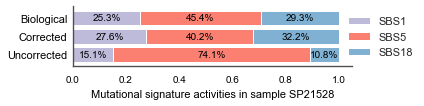

In [12]:
df_tmp = df_example_act.T
sns.set(rc={"figure.figsize":(5, 1.1)})
sns.set(style="white", color_codes=True, rc={"grid.linewidth": 0.2, 'grid.color': '.7', 'ytick.major.size': 2,
                                                 'axes.edgecolor': '.3', 'axes.linewidth': 1.35,})
ax = df_tmp.plot(kind = 'barh', stacked = True, 
                        #title = 'Percentage of mutation subtypes', 
                        mark_right = True,
                        width = 0.8,
                        color = sns.color_palette("Set3")[2:5])
ax.legend(bbox_to_anchor=(0.95, 1),frameon = False)
plt.yticks(np.arange(len(df_tmp.index)), [i.split(" ")[0] for i in df_tmp.index], 
           color = "black")

df_rel = df_tmp * 100

text_color = ['black','black','black']
for j,n in enumerate(df_rel): 
    for i, (cs, ab, pc) in enumerate(zip(df_tmp.cumsum(1)[n],  
                                         df_tmp[n], df_rel[n])): 
        plt.text (cs - ab / 2, i, str(np.round(pc, 1)) + '%',  
                 va = 'center', ha = 'center', color = text_color[j], size = 10)
sns.despine()
plt.xticks (size = 10, color = "black")
plt.xlabel("Mutational signature activities in sample " + sample_id, color = "black", size = 11)
plt.savefig("./Figures/Fig2b.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

## 2.2 Correction results for all simulated FFPE samples

**NOTE:** The correction process is the same for all PCAWG samples as shown in the above example. To save time, we did parallel-run in our local HPC cluster. Here, we will read the collected results for all samples from the cluster.

### 2.2.1 Comparing correction accuracy using 96-channel (all mutations) versus using 16-channel C>T mutations

Because FFPE artefacts are mostly distributed in C>T channels, our correction method will subtract noise mutaion counts mostly also from C>T channels. Therefore, using all 96-channel will increase the accuracy slightly, but this increase is very minor. So we focus on on C>T channels for accuracy calculation, which is more precise.

In [13]:
## unrepaired FFPE:
unrepaired_profiles_corrected = pd.read_csv("./Data/unrepaired_profiles_corrected.csv", sep ="\t")

## Repaired FFPEs:
repaired_profiles_corrected = pd.read_csv("./Data/repaired_profiles_corrected.csv", sep ="\t")

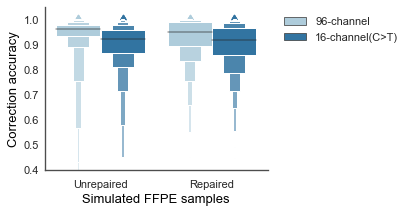

In [14]:
## 96-channel
C2T_ind = ["C>T" == t for t in profiles['Mutation type']]

n_channel = unrepaired_profiles_corrected.shape[0]
## unrepaired
accuracy = [cosine_similarity(profile_values[col].to_numpy().reshape(1,n_channel), 
                        unrepaired_profiles_corrected[col].to_numpy().reshape(1,n_channel))[0][0] 
                        for col in unrepaired_profiles_corrected.columns[1:]]
group = ["Unrepaired"] * len(unrepaired_profiles_corrected.columns[1:])

## repaired
accuracy += [cosine_similarity(profile_values[col].to_numpy().reshape(1,n_channel), 
                        repaired_profiles_corrected[col].to_numpy().reshape(1,n_channel))[0][0] 
                        for col in unrepaired_profiles_corrected.columns[1:]]

group += ["Repaired"] * len(unrepaired_profiles_corrected.columns[1:])
labels = ["96-channel"] * len(unrepaired_profiles_corrected.columns[1:]) * 2

## 16-channel
n_channel = np.sum(C2T_ind)
## unrepaired
accuracy += [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1,n_channel), 
                        unrepaired_profiles_corrected[col][C2T_ind].to_numpy().reshape(1,n_channel))[0][0] 
                        for col in unrepaired_profiles_corrected.columns[1:]]
group += ["Unrepaired"] * len(unrepaired_profiles_corrected.columns[1:])

## repaired
accuracy += [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1,n_channel), 
                        repaired_profiles_corrected[col][C2T_ind].to_numpy().reshape(1,n_channel))[0][0] 
                        for col in repaired_profiles_corrected.columns[1:]]
group += ["Repaired"] * len(unrepaired_profiles_corrected.columns[1:])
labels += ["16-channel(C>T)"] * len(unrepaired_profiles_corrected.columns[1:]) * 2

## for plotting
f, ax = plt.subplots (figsize = (4,3))
df_acc_diff_channel = pd.DataFrame()
accuracy_changes = pd.DataFrame({"Group": group,
                                 "Label": labels,
                                 "Accuracy":accuracy})

sns.boxenplot(x = "Group", y = "Accuracy", data = accuracy_changes, hue = "Label", 
                       palette= sns.color_palette("Paired")[0:2], ax = ax)
ax.set_ylim (0.4,1.05)
#ax.set_xticklabels(['Before\ncorrection','After\ncorrection'])
ax.set_xlabel ("Simulated FFPE samples", color = "black", size = 13)
ax.set_ylabel("Correction accuracy", size = 13, color = "black")
plt.legend(bbox_to_anchor=(1.03, 1),frameon = False)
sns.despine()
plt.savefig ("./Figures/SFig6.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

### 2.2.2 Collecting correction results for unrepaired FFPEs

In [15]:
## collecting accuracy
C2T_ind = ["C>T" in t for t in profiles['Mutation type']]
n_channel = np.sum(C2T_ind)
accuracy_unrepaired = [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1,n_channel), 
                        unrepaired_profiles_corrected[col][C2T_ind].to_numpy().reshape(1,n_channel))[0][0] 
                       for col in unrepaired_profiles_corrected.columns[1:]]

## computing similarities between FFPE sig (the noise) and the original profile(the signal)
similarity_unrepaired = [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1,n_channel), 
                            ffpe_sig_unrepaired[C2T_ind].reshape(1,n_channel))[0][0] 
                         for col in unrepaired_profiles_corrected.columns[1:]]

## Build dataframe
unrepaired_stat = pd.DataFrame()
unrepaired_stat['Samples'] = profiles.columns[2:]
unrepaired_stat['Cancer_type'] = [col.split("::")[0] for col in profiles.columns[2:]]

unrepaired_stat['Correction_accuracy'] = accuracy_unrepaired
unrepaired_stat['Similarity_FFPEsig_original'] = similarity_unrepaired


## label the similarity group: top 10% as high, bottom 10% as low, others are middle
sim_values_unrepaired = unrepaired_stat.Similarity_FFPEsig_original.values
sim_lower, sim_upper = np.quantile(sim_values_unrepaired, [0.1,0.9])
unrepaired_stat['similarity_label'] = "Middle"
unrepaired_stat['similarity_label'].values[sim_values_unrepaired < sim_lower] = "Low"
unrepaired_stat['similarity_label'].values[sim_values_unrepaired > sim_upper] = "High"


load_values = profiles.iloc[:,2:].loc[C2T_ind,:].sum()
unrepaired_stat['Mutationload_C2T'] = load_values.values
## label the mutation load group: top 10% as high, bottom 10% as low, others are middle
load_lower, load_upper = np.quantile(unrepaired_stat['Mutationload_C2T'], [0.1,0.9])

unrepaired_stat['mutationload_label'] = "Middle"
unrepaired_stat['mutationload_label'].values[unrepaired_stat['Mutationload_C2T'] < load_lower] = "Low"
unrepaired_stat['mutationload_label'].values[unrepaired_stat['Mutationload_C2T'] > load_upper] = "High"
unrepaired_stat['noise_load'] = unrepaired_noise_loads
unrepaired_stat.head(2)

,Samples,Cancer_type,Correction_accuracy,Similarity_FFPEsig_original,similarity_label,Mutationload_C2T,mutationload_label,noise_load
0,Biliary-AdenoCA::SP117655,Biliary-AdenoCA,0.958161,0.808912,Middle,5419,Middle,10107
1,Biliary-AdenoCA::SP117556,Biliary-AdenoCA,0.939867,0.577183,Middle,1998,Middle,10010


### 2.2.3 Collecting correction results for repaired FFPEs

In [16]:
## collecting accuracy
accuracy_repaired = [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1,n_channel), 
                    repaired_profiles_corrected[col][C2T_ind].to_numpy().reshape(1, n_channel))[0][0] 
                    for col in repaired_profiles_corrected.columns[1:]]

## computing similarities between FFPE sig (the noise) and the original profile(the signal)
similarity_repaired = [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1, n_channel), 
                      ffpe_sig_repaired[C2T_ind].reshape(1,n_channel))[0][0] 
                      for col in repaired_profiles_corrected.columns[1:]]

## Build dataframe
repaired_stat = pd.DataFrame()
repaired_stat['Samples'] = profiles.columns[2:]
repaired_stat['Cancer_type'] = [col.split("::")[0] for col in profiles.columns[2:]]

repaired_stat['Correction_accuracy'] = accuracy_repaired
repaired_stat['Similarity_FFPEsig_original'] = similarity_repaired


## label the similarity group: top 10% as high, bottom 10% as low, others are middle
sim_values_repaired = repaired_stat.Similarity_FFPEsig_original.values
sim_lower, sim_upper = np.quantile(sim_values_repaired, [0.1,0.9])
repaired_stat['similarity_label'] = "Middle"
repaired_stat['similarity_label'].values[sim_values_repaired < sim_lower] = "Low"
repaired_stat['similarity_label'].values[sim_values_repaired > sim_upper] = "High"


load_values = profiles.iloc[:,2:].loc[C2T_ind,:].sum()
repaired_stat['Mutationload_C2T'] = load_values.values
## label the mutation load group: top 10% as high, bottom 10% as low, others are middle
load_lower, load_upper = np.quantile(repaired_stat['Mutationload_C2T'], [0.1,0.9])

repaired_stat['mutationload_label'] = "Middle"
repaired_stat['mutationload_label'].values[repaired_stat['Mutationload_C2T'] < load_lower] = "Low"
repaired_stat['mutationload_label'].values[repaired_stat['Mutationload_C2T'] > load_upper] = "High"
repaired_stat['noise_load'] = repaired_noise_loads

repaired_stat.head(2)

,Samples,Cancer_type,Correction_accuracy,Similarity_FFPEsig_original,similarity_label,Mutationload_C2T,mutationload_label,noise_load
0,Biliary-AdenoCA::SP117655,Biliary-AdenoCA,0.936023,0.668683,Middle,5419,Middle,10108
1,Biliary-AdenoCA::SP117556,Biliary-AdenoCA,0.872684,0.951708,High,1998,Middle,9856


### 2.2.4 Overall correction accuracy

In [17]:
cutoffs = np.array([0.8, 0.825,0.85,0.875,0.9, 0.925, 0.95, 0.975])
passed_ratios_unrepaired = []
passed_counts_unrepaired = []
passed_ratios_repaired = []
passed_counts_repaired = []

for i in cutoffs:
    passed_ratio_tmp = np.sum(unrepaired_stat['Correction_accuracy'] > i) / unrepaired_stat.shape[0]
    passed_ratios_unrepaired.append(passed_ratio_tmp)
    passed_counts_unrepaired.append(np.sum(unrepaired_stat['Correction_accuracy'] > i))
    
    passed_ratio_tmp = np.sum(repaired_stat['Correction_accuracy'] > i) / repaired_stat.shape[0]
    passed_ratios_repaired.append(passed_ratio_tmp)
    passed_counts_repaired.append(np.sum(repaired_stat['Correction_accuracy'] > i))
    
passed_ratio_df = pd.DataFrame({"Cutoffs": cutoffs, "unrepaired_ratio" : passed_ratios_unrepaired,
                                'unrepaired_counts': passed_counts_unrepaired,
                               "repaired_ratio" : passed_ratios_repaired,
                               "repaired_counts" : passed_counts_repaired})
passed_ratio_df

,Cutoffs,unrepaired_ratio,unrepaired_counts,repaired_ratio,repaired_counts
0,0.800,0.887770,2468,0.860072,2391
1,0.825,0.849640,2362,0.825180,2294
2,0.850,0.794964,2210,0.764748,2126
3,0.875,0.716906,1993,0.688129,1913
4,0.900,0.604317,1680,0.584532,1625
5,0.925,0.478417,1330,0.460072,1279
6,0.950,0.311871,867,0.329856,917
7,0.975,0.132014,367,0.196403,546


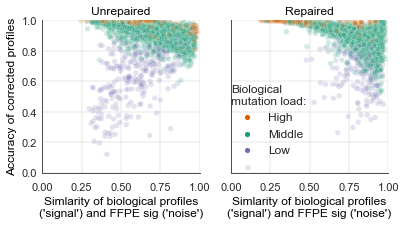

In [18]:
## overall correction accuracy
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.3, 'grid.color': '.7', 
                                                 'ytick.major.size': 2,'axes.edgecolor': '.3', 
                                                 'axes.linewidth': 1})
f, (ax1, ax2) = plt.subplots(1,2, figsize=(6.2, 2.8), sharey = True, sharex =True)

sns.scatterplot(x = "Similarity_FFPEsig_original", y = "Correction_accuracy", 
                hue = "mutationload_label", palette = "Dark2",
                data = unrepaired_stat,  alpha = 0.2, s = 30, ax = ax1)

handles, labels = ax1.get_legend_handles_labels()

ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.legend ('', frameon = False)
ax1.set_xlabel("Simlarity of biological profiles\n('signal') and FFPE sig ('noise')", 
           size = 12, color = "black")
ax1.set_ylabel("Accuracy of corrected profiles", size = 12, color = "black")
ax1.set_title ("Unrepaired", color = "black", size = 12)


sns.scatterplot(x = "Similarity_FFPEsig_original", y = "Correction_accuracy", 
                hue = "mutationload_label", palette = "Dark2",
                data = repaired_stat,  alpha = 0.2, s = 30, ax = ax2, legend = None )

ax2.legend([handles[2], handles[1], handles[3]],
           [labels[2], labels[1], labels[3]], 
           bbox_to_anchor=(0.55, 0.65), 
           frameon = False, title = "Biological\nmutation load:", 
           fontsize = 12, markerscale = 0.7, ncol = 1)

ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
sns.despine()
ax2.set_xlabel ("Simlarity of biological profiles\n('signal') and FFPE sig ('noise')",
                size = 12, color = "black")
ax2.set_title ("Repaired", color = "black", size = 12)
plt.savefig("./Figures/Fig2b.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

In [19]:
unrepaired_mean = np.mean(unrepaired_stat['Correction_accuracy'])
unrepaired_CI = np.around(CI(unrepaired_stat['Correction_accuracy']),3)
print ("Unrepaired FFPE correction")
print (f'Mean:{unrepaired_mean:.3f}, 95% CI:{unrepaired_CI}')

repaired_mean = np.mean(repaired_stat['Correction_accuracy'])
repaired_CI = np.around(CI(repaired_stat['Correction_accuracy']),3)
print ("Repaired FFPE correction")
print (f'Mean:{repaired_mean:.3f}, 95% CI:{repaired_CI}')

Unrepaired FFPE correction
Mean:0.891, 95% CI:[0.887 0.895]
Repaired FFPE correction
Mean:0.893, 95% CI:[0.889 0.897]


 ## 2.3 Possible factors affecting the noise correction accuracy

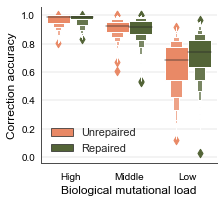

In [20]:
unrepaired_stat['label'] = "Unrepaired"
repaired_stat['label'] = "Repaired"
combined_stat = pd.concat((unrepaired_stat,repaired_stat))

sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.3, 'grid.color': '.7', 
                                                 'ytick.major.size': 2,'axes.edgecolor': '.3', 
                                                 'axes.linewidth': 1})
#ax.set(yscale="log")
sns.catplot(x = 'mutationload_label', y = 'Correction_accuracy', kind = 'boxen', hue = "label",legend= None,
            data = combined_stat,height = 3, aspect = 1.1,
            order = ['High', 'Middle', 'Low'],palette=['coral','darkolivegreen'])
plt.ylabel ("Correction accuracy",  size = 12, color = "black") 
plt.xlabel("Biological mutational load",size = 12, color = "black")
plt.xticks (size = 10, color = "black")
plt.yticks (size = 10, color = "black")
plt.legend(loc = "lower left",frameon = False)
plt.setp(f.lines, color=".9")
plt.savefig("./Figures/Fig2e.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

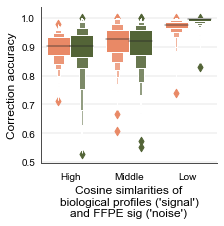

In [21]:
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.3, 'grid.color': '.7', 
                                                 'ytick.major.size': 2,'axes.edgecolor': '.3',
                                                 'axes.linewidth': 1})
df_tmp = combined_stat.loc[list(combined_stat.mutationload_label.values !="Low"),:]
sns.catplot(x = 'similarity_label', y = 'Correction_accuracy', kind = 'boxen', hue = "label",legend= None,
            data = df_tmp, height = 3, aspect = 1.1,
            order = ['High', 'Middle', 'Low'],palette=['coral','darkolivegreen'])
plt.ylabel ("Correction accuracy",  size = 12, color = "black")
plt.xlabel("Cosine simlarities of\nbiological profiles ('signal')\nand FFPE sig ('noise')", 
           size = 12, color = "black")
plt.xticks (size = 10, color = "black")
plt.yticks (size = 10, color = "black")
plt.savefig("./Figures/Fig2f.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

## 2.4 Correction accuracy grouped by main cancer types

In [22]:
## main cancer types include more than 20 samples within the cancer type:
cancer_types_count = unrepaired_stat.groupby('Cancer_type')['Samples'].count()
main_cancer_types = cancer_types_count.index[cancer_types_count > 20]

unrepaired_stat_filtered = unrepaired_stat.loc[[ctype in main_cancer_types for 
                                                ctype in unrepaired_stat.Cancer_type],:].copy()

repaired_stat_filtered = repaired_stat.loc[[ctype in main_cancer_types for 
                                                ctype in repaired_stat.Cancer_type],:].copy()

## combine unrepaired and repaired FFPE data together
repaired_stat_filtered['label'] = "Repaired"
unrepaired_stat_filtered['label'] = "Unrepaired"
combined_stat_mainCancerTypes = pd.concat((unrepaired_stat_filtered, repaired_stat_filtered))
combined_stat_mainCancerTypes.head(2)

,Samples,Cancer_type,Correction_accuracy,Similarity_FFPEsig_original,similarity_label,Mutationload_C2T,mutationload_label,noise_load,label
0,Biliary-AdenoCA::SP117655,Biliary-AdenoCA,0.958161,0.808912,Middle,5419,Middle,10107,Unrepaired
1,Biliary-AdenoCA::SP117556,Biliary-AdenoCA,0.939867,0.577183,Middle,1998,Middle,10010,Unrepaired


In [23]:
combined_stat_mainCancerTypes.columns

Index(['Samples', 'Cancer_type', 'Correction_accuracy',
       'Similarity_FFPEsig_original', 'similarity_label', 'Mutationload_C2T',
       'mutationload_label', 'noise_load', 'label'],
      dtype='object')

### 2.4.1 Sorted cancer types based on overall mean accuracy

In [24]:
combined_stat_mainCancerTypes['MutationLoad'] = [profile_values[sample][C2T_ind].sum() 
                                                 for sample in combined_stat_mainCancerTypes['Samples'].values]
combined_stat_mainCancerTypes.groupby ('Cancer_type').mean().sort_values(by="Correction_accuracy",
                                                                        ascending = False)

,Correction_accuracy,Similarity_FFPEsig_original,Mutationload_C2T,noise_load,MutationLoad
Cancer_type,,,,,
Skin-Melanoma,0.983318,0.552308,96361.869159,9998.411215,96361.869159
Bladder-TCC,0.970325,0.611615,8628.260870,9984.000000,8628.260870
Lung-SCC,0.958117,0.698118,9248.437500,10014.270833,9248.437500
CNS-GBM,0.957995,0.668049,8701.195122,9980.865854,8701.195122
ColoRect-AdenoCA,0.952101,0.687029,40840.500000,9985.566667,40840.500000
Uterus-AdenoCA,0.939037,0.721116,23086.470588,10012.245098,23086.470588
Lung-AdenoCA,0.934469,0.711122,7280.131579,10001.302632,7280.131579
Liver-HCC,0.933968,0.750857,2669.822086,9999.384969,2669.822086
Head-SCC,0.931422,0.696998,5544.666667,10001.394737,5544.666667


### 2.4.2 Mean accuracy for repaired and unrepaired FFPEs for each cancer type

In [25]:
combined_stat_mainCancerTypes.groupby (by = ["label",'Cancer_type']).mean()

Correction_accuracy  Similarity_FFPEsig_original  \
label      Cancer_type                                                          
Repaired   Biliary-AdenoCA              0.917996                     0.724266   
           Bladder-TCC                  0.969315                     0.480762   
           Bone-Osteosarc               0.907757                     0.680391   
           Breast-AdenoCA               0.905529                     0.709154   
           CNS-GBM                      0.941376                     0.898029   
           CNS-Medullo                  0.812388                     0.923873   
           CNS-PiloAstro                0.698641                     0.882003   
           ColoRect-AdenoCA             0.935775                     0.888935   
           Eso-AdenoCA                  0.888537                     0.833313   
           Head-SCC                     0.922163                     0.626076   
           Kidney-ChRCC                 0.828891                     0.886389   
           Kidney-RCC                   0.939367                     0.646504   
           Liver-HCC                    0.970967                     0.571314   
           Lung-AdenoCA                 0.936729                     0.594303   
           Lung-SCC                     0.980979                     0.479889   
           Lymph-BNHL                   0.893500                     0.805457   
           Lymph-CLL                    0.846016                     0.833721   
           Myeloid-MPN                  0.809005                     0.816147   
           Ovary-AdenoCA                0.906398                     0.758766   
           Panc-AdenoCA                 0.901836                     0.900069   
           Panc-Endocrine               0.857493                     0.687465   
           Prost-AdenoCA                0.848423                     0.904055   
           Skin-Melanoma                0.983956                     0.387249   
           Stomach-AdenoCA              0.873289                     0.846603   
           Thy-AdenoCA                  0.813907                     0.733755   
           Uterus-AdenoCA               0.920361                     0.775985   
Unrepaired Biliary-AdenoCA              0.924295                     0.793172   
           Bladder-TCC                  0.971335                     0.742468   
           Bone-Osteosarc               0.875745                     0.861320   
           Breast-AdenoCA               0.927729                     0.763780   
           CNS-GBM                      0.974614                     0.438069   
           CNS-Medullo                  0.829156                     0.547054   
           CNS-PiloAstro                0.522122                     0.496126   
           ColoRect-AdenoCA             0.968427                     0.485122   
           Eso-AdenoCA                  0.921870                     0.728906   
           Head-SCC                     0.940682                     0.767921   
           Kidney-ChRCC                 0.889961                     0.604703   
           Kidney-RCC                   0.861504                     0.915235   
           Liver-HCC                    0.896969                     0.930400   
           Lung-AdenoCA                 0.932209                     0.827941   
           Lung-SCC                     0.935255                     0.916348   
           Lymph-BNHL                   0.893151                     0.788297   
           Lymph-CLL                    0.879317                     0.743707   
           Myeloid-MPN                  0.831408                     0.692999   
           Ovary-AdenoCA                0.886405                     0.831826   
           Panc-AdenoCA                 0.952150                     0.591624   
           Panc-Endocrine               0.831003                     0.839346   
           Prost-AdenoCA                0.908703            

### 2.4.3 Well-correction samples (accuracy > 0.9)

In [26]:
## Compute the percentage of well reconstructed samples in each type 
def collect_well_reconstructed_ratio (df):
    ratios = []
    types = []
    cutoff = 0.9
    for ctype in df["Cancer_type"].unique():
        passed = sum(df.loc[df.Cancer_type == ctype, "Correction_accuracy"] >= cutoff)
        total = sum(df.Cancer_type == ctype)
        ratio = passed/total
        ratios.append(ratio)
        types.append(ctype)
    ratio_df = pd.DataFrame({'Cancer_type':types, 'ratios': ratios})
    ratio_df = ratio_df.sort_values(by=['ratios'], ascending = False)
    return (ratio_df)

unrepaired_ratio_df = collect_well_reconstructed_ratio(df = unrepaired_stat_filtered.copy())
repaired_ratio_df = collect_well_reconstructed_ratio(df = repaired_stat_filtered.copy())

well_constructed_df = unrepaired_ratio_df.merge(repaired_ratio_df,on = 'Cancer_type', suffixes = ("_unrepaired",
                                                                                                  "_repaired"))
well_constructed_df_sorted = well_constructed_df.sort_values('ratios_unrepaired', ascending = False)

p_values = []
for ct in well_constructed_df_sorted.Cancer_type:
    x1 = unrepaired_stat_filtered.loc[unrepaired_stat_filtered.Cancer_type == ct,
                                 :]['Correction_accuracy'].values
    x2 = repaired_stat_filtered.loc[repaired_stat_filtered.Cancer_type == ct,
                                 :]['Correction_accuracy'].values
    t, p = mannwhitneyu(x1, x2, alternative='two-sided')
    p_values.append(p)

well_constructed_df_sorted['p_value'] = p_values

p_labels = []
for p in well_constructed_df_sorted['p_value']:
    if p < 0.001:
        p_labels.append("***")
    elif p < 0.01 and p > 0.001:
        p_labels.append("**")
    elif p < 0.05 and p > 0.01:
        p_labels.append("*")
    else:
        p_labels.append("")
        
well_constructed_df_sorted['labels'] = p_labels

unrepaired_ratio_num = (np.around(well_constructed_df_sorted.ratios_unrepaired,
                                  2) * 100 ).astype("int").values
repaired_ratio_num = (np.around(well_constructed_df_sorted.ratios_repaired,
                                  2) * 100 ).astype("int").values

well_constructed_df_sorted

,Cancer_type,ratios_unrepaired,ratios_repaired,p_value,labels
0,CNS-GBM,1.000000,0.926829,1.453413e-07,***
1,ColoRect-AdenoCA,0.983333,0.750000,9.354066e-04,***
2,Skin-Melanoma,0.943925,0.962617,2.545433e-02,*
3,Uterus-AdenoCA,0.941176,0.647059,8.874570e-03,**
4,Panc-AdenoCA,0.917012,0.589212,5.297804e-29,***
5,Bladder-TCC,0.869565,0.913043,8.777798e-01,
6,Lung-AdenoCA,0.868421,0.763158,8.746152e-02,
7,Head-SCC,0.842105,0.736842,2.273902e-01,
8,Lung-SCC,0.833333,1.000000,2.526729e-11,***
9,Eso-AdenoCA,0.795918,0.408163,3.618516e-10,***


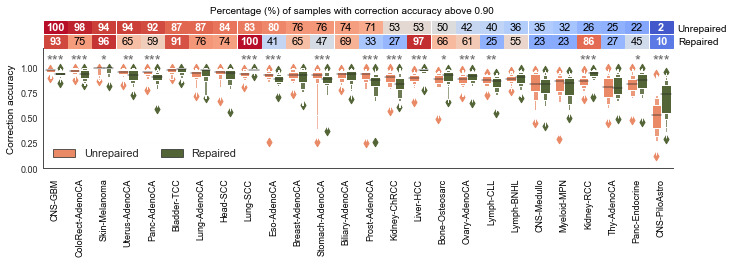

In [27]:
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.01, 'grid.color': '.7', 
                                                 'ytick.major.size': 2, 'axes.edgecolor': '.3', 
                                                 'axes.linewidth': 1})

sns.catplot(x = 'Cancer_type', y = 'Correction_accuracy', palette=['coral','darkolivegreen'],
            data = combined_stat_mainCancerTypes, order = well_constructed_df_sorted.Cancer_type.values, 
            hue = "label",legend= None, kind = 'boxen', height = 2.5, aspect = 4,)
plt.xticks(rotation = 90, size = 9, color = "black")
plt.yticks( size = 9)

plt.xlabel ("")
plt.ylim(0, 1.2)
plt.legend(loc = "lower left", ncol = 2, frameon = False)
plt.ylabel ("Correction accuracy",  size = 10, color = "black")
cutoff = 0.9
Targeted_cancers = unrepaired_ratio_df.Cancer_type.values
length = len(Targeted_cancers)
for i in range(length):
    ## bottom pannel color bars 
    left, width = 0 + 1/length * i + 0.001, 1/length - 0.002        
    bottom, height = 1.12, 0.10
    right = left + width
    top = bottom + height
    ax = plt.gca()
    col_ind = unrepaired_ratio_num[i]
    colors =sns.color_palette("coolwarm", np.max(unrepaired_ratio_num) +1) 
    p = plt.Rectangle((left, bottom), width, height, fill=True, color = colors[col_ind])
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    
    if col_ind > 20 and col_ind < 80:
        ax.text(0.5 * (left + right), 0.5 * (bottom + top), unrepaired_ratio_num[i], 
            color = "black", size = 11,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(0.5 * (left + right), 0.5 * (bottom + top), unrepaired_ratio_num[i], 
            color = "w",weight = "bold", size = 11,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    
    ax.text(0.5 * (left + right), 0.38 * (bottom + top), well_constructed_df_sorted['labels'][i], 
            color = "dimgrey", size = 15,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    ## top pannel color bars
    left, width = 0 + 1/length * i + 0.001, 1/length - 0.002
        
    bottom, height = 1.003, 0.10
    right = left + width
    top = bottom + height
    ax = plt.gca()
    col_ind = repaired_ratio_num[i]
    colors =sns.color_palette("coolwarm", np.max(repaired_ratio_num) +1) 
    p = plt.Rectangle((left, bottom), width, height, fill=True, color = colors[col_ind])
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    
    if col_ind > 20 and col_ind < 80:
        ax.text(0.5 * (left + right), 0.5 * (bottom + top), repaired_ratio_num[i], 
            color = "black", size = 11,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(0.5 * (left + right), 0.5 * (bottom + top), repaired_ratio_num[i], 
            color = "w",weight = "bold", size = 11,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
## top pannel annotation
ax.text(0.53*(left + right), 0.5 *(bottom + top), "Repaired", 
            color = "black", size = 10,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)   
## bottom pannel annotation
ax.text(0.533*(left + right), 0.55 *(bottom + top), "Unrepaired", 
            color = "black", size = 10,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax.text(0.25*(left + right), 0.62 *(bottom + top), 
        f"Percentage (%) of samples with correction accuracy above {cutoff:.2f}", 
        color = "black", size = 10,
        horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
plt.savefig("./Figures/Fig2d.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

## 2.5 Correction accuracy with increasing FFPE noise load

### 2.5.1 Simulating data

In [28]:
## selecting cancer types with 80% of well-corrected samples for repaired and unrepaired FFPEs:

well_constructed_cancers = well_constructed_df.Cancer_type[[r1 > 0.8 and r2 > 0.8 
                                 for r1,r2 in zip (well_constructed_df.ratios_unrepaired, 
                                                   well_constructed_df.ratios_repaired)]].values

well_constructed_cancer_profiles = profile_values.loc[:,[t.split("::")[0] in well_constructed_cancers
                                                         for t in profile_values.columns]]
well_constructed_cancers, well_constructed_cancer_profiles.shape

(array(['CNS-GBM', 'Skin-Melanoma', 'Bladder-TCC', 'Lung-SCC'],
       dtype=object),
 (96, 219))

In [29]:
for level, load in zip([1,3,4,5],[10**3, 5*10**4, 10**5, 10**6]):
    simulated_df_unrepaired, simulated_df_repaired = pd.DataFrame(), pd.DataFrame()
    for i, col in enumerate(well_constructed_cancer_profiles.columns):
        npr.seed(i + 1)
        sample = well_constructed_cancer_profiles[col].to_numpy()
        simulated_df_unrepaired [col] = simulation(sample_indvidual = sample, 
                                                    ffpe_sig = ffpe_sig_unrepaired, 
                                                    ffpe_load = load)
    
        simulated_df_repaired [col] = simulation(sample_indvidual = sample, 
                                                    ffpe_sig = ffpe_sig_repaired, 
                                                    ffpe_load = load)
    ## write the simulated samples to Data folder
    simulated_df_unrepaired.to_csv ("./Data/Different_FFPEloads/simulated_PCAWG_FFPE_unrepaired_L" + 
                                    str(level) + ".csv", index = False)
    simulated_df_repaired.to_csv ("./Data/Different_FFPEloads/simulated_PCAWG_FFPE_repaired_L" + 
                                    str(level) + ".csv", index = False)

## Level 2 noise is 10**4, the same with previous simulated results:    
simulated_df_unrepaired_10_4.loc[:,well_constructed_cancer_profiles.columns].to_csv (
    "./Data/Different_FFPEloads/simulated_PCAWG_FFPE_unrepaired_L2.csv",index = False)
simulated_df_repaired_10_4.loc[:,well_constructed_cancer_profiles.columns].to_csv (
    "./Data/Different_FFPEloads/simulated_PCAWG_FFPE_repaired_L2.csv",index = False)

In [30]:
## signal-to-noise ratio under 10^6 noise
np.median(well_constructed_cancer_profiles.loc[C2T_ind,:].sum() / 1000000)

0.008836

### 2.5.2 Read the corrected results

The correction on noise-changed samples is performed on local HPC cluster as well.

In [31]:
cancer_list, sample_list, accuracy_list, level_list, ffpe_load_list, label_list = [], [], [], [], [], []

path = "./Data/Different_FFPEloads/"

for label in ['unrepaired', 'repaired']:
    for level, ffpe_load in zip(['L1','L2','L3','L4','L5'],[10**3, 10**4, 5*10**4, 10**5, 10**6]): 
        corrected_profiles_DiffLevel = pd.read_csv(path + label + "_profiles_corrected_" + level +".csv",
                                          sep = "\t")

        cancer = [col.split("::")[0] for col in corrected_profiles_DiffLevel.columns[1:]]
        cancer_list += cancer

        sample = [col.split("::")[1] for col in corrected_profiles_DiffLevel.columns[1:]]
        sample_list += sample
        n_channel = np.sum(C2T_ind)
        accuracy_correction = [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1,n_channel), 
                                corrected_profiles_DiffLevel[col][C2T_ind].to_numpy().reshape(1,n_channel))[0][0] 
                               for col in corrected_profiles_DiffLevel.columns[1:]]
        accuracy_list += accuracy_correction

        level_list += [level] * len(accuracy_correction)
        ffpe_load_list += [ffpe_load] * len(accuracy_correction)
        label_list += [label] * len(accuracy_correction)

## making dataframe using the collected data        
correction_stats_DiffLevel = pd.DataFrame({'Cancer_type' : cancer_list,
                                         'Sample' : sample_list,
                                         'Accuracy' : accuracy_list,
                                         'Noise_level' : level_list,
                                         'FFPE_load' : ffpe_load_list,
                                         'Label' : label_list})
correction_stats_DiffLevel.head(2)

,Cancer_type,Sample,Accuracy,Noise_level,FFPE_load,Label
0,Bladder-TCC,SP1086,0.961940,L1,1000,unrepaired
1,Bladder-TCC,SP1003,0.994193,L1,1000,unrepaired


## 2.6 Getting the mean correction accuracy over different noise levels

In [32]:
correction_stats_DiffLevel.groupby(['Label', 'Noise_level'])['Accuracy'].mean()

Label       Noise_level
repaired    L1             0.979199
            L2             0.973794
            L3             0.953039
            L4             0.940261
            L5             0.838469
unrepaired  L1             0.970679
            L2             0.969585
            L3             0.955554
            L4             0.944876
            L5             0.858575
Name: Accuracy, dtype: float64

In [33]:
correction_stats_DiffLevel.groupby(['Label', 'Noise_level'])['Accuracy'].apply(lambda x: CI(x))

Label       Noise_level
repaired    L1              (0.9756624600526129, 0.982736515525874)
            L2             (0.9692287818231393, 0.9783595621691077)
            L3             (0.9431724708764628, 0.9629062776132353)
            L4              (0.9276245142014552, 0.952896766072163)
            L5             (0.8085370992981799, 0.8683999474704648)
unrepaired  L1             (0.9655623026835115, 0.9757964715437765)
            L2             (0.9645432601938968, 0.9746258622986861)
            L3              (0.947996174621193, 0.9631128041288023)
            L4             (0.9356675672639271, 0.9540836368361881)
            L5             (0.8369054034214508, 0.8802439617373109)
Name: Accuracy, dtype: object

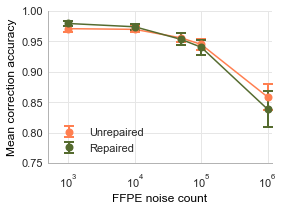

In [34]:
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 1, 'grid.color': '.9', 
                                                 'ytick.major.size': 2,'axes.edgecolor': '.7',
                                                 'axes.linewidth': 1,'figure.figsize':(4,2.8)})
f, ax = plt.subplots()
ax.set(xscale="log")

noise_levels = [10**3, 10**4, 5*10**4, 10**5, 10**6]

## unrepaired
df_tmp = correction_stats_DiffLevel[correction_stats_DiffLevel['Label'] == "unrepaired"]

level_means = df_tmp.groupby('Noise_level').mean()['Accuracy']
level_lower_limits = df_tmp.groupby('Noise_level')['Accuracy'].apply(lambda x: CI(x)[0])
level_higher_limits = df_tmp.groupby('Noise_level')['Accuracy'].apply(lambda x: CI(x)[1])

plt.plot(noise_levels, level_means, color = "coral")
plt.errorbar(noise_levels, level_means, 
             yerr = [level_means - level_lower_limits, level_higher_limits - level_means], 
             fmt = "o", capsize=5, elinewidth = 2, markeredgewidth = 2,
             color = "coral", label = "Unrepaired")

## repaired
df_tmp = correction_stats_DiffLevel[correction_stats_DiffLevel['Label'] == "repaired"].copy()

level_means = df_tmp.groupby('Noise_level').mean()['Accuracy']
level_lower_limits = df_tmp.groupby('Noise_level')['Accuracy'].apply(lambda x: CI(x)[0])
level_higher_limits = df_tmp.groupby('Noise_level')['Accuracy'].apply(lambda x: CI(x)[1])

plt.plot(noise_levels, level_means, color = "darkolivegreen")
plt.errorbar(noise_levels, level_means, 
             yerr = [level_means - level_lower_limits, level_higher_limits - level_means], 
             fmt = "o", capsize=5, elinewidth=2, markeredgewidth=2,
             color = "darkolivegreen", label = "Repaired")

plt.xlim (500, 10**6 + 150000)
plt.ylim(0.75, 1)

plt.legend(loc = "lower left", frameon = False)
plt.xlabel ("FFPE noise count", size = 12, color = "black")
plt.ylabel("Mean correction accuracy",size = 12, color = "black")
sns.despine()
plt.savefig("./Figures/Fig2g.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

# 3. Compare inferred signature activities using uncorrected FFPE and corrected FFPE

+ We are interested in decomposition results on uncorrected FFPE and corrected profiles.
+ We use the decomposition results from real biological profile as a control.

Creat dict object for signatures with known aetiology:

In [35]:
sig_aetiology_dict = {"Clock-like":["SBS1"], 
                      "APOBEC":["SBS2","SBS13"],
                      "HR deficiency" : ["SBS3"], 
                      "Tobacco" : ["SBS4", "SBS29"], 
                      "MMR deficiency" : ["SBS6",'SBS14',"SBS15","SBS20", "SBS21","SBS26", "SBS44"],
                      "POLE" : ["SBS10a", "SBS10b"],
                      "UV light" : ["SBS7a", "SBS7b","SBS7c","SBS7d"],
                      'ROS damage':['SBS18'],
                      "BER deficiency" : ["SBS30", "SBS36"],
                      "Treatment exposure" : [ "SBS31", "SBS32", "SBS35"],
                      'Mutagen exposure' : ["SBS22", 'SBS24', "SBS42"]}
aetiology_list = list(sig_aetiology_dict.keys())

## 3.1 Infer activities from FFPE samples

### 3.1.1 For unrepaired FFPEs

Select PCAWG samples with correction accuracy above 0.9

In [36]:
well_corrected_samples_unrepaired_df = unrepaired_stat.loc[unrepaired_stat['Correction_accuracy'] > 0.9, :]
well_corrected_samples_unrepaired = well_corrected_samples_unrepaired_df['Samples'].values
len(well_corrected_samples_unrepaired), len(well_corrected_samples_unrepaired)/unrepaired_stat.shape[0]

(1680, 0.60431654676259)

We infer mutational signature activities for three profiles in each sample:
+ Biological profile;
+ Corrected FFPE profile;
+ Uncorrected FFPE profile.

We also compute the reconstruction accuracy between the real biological profiles to the reconstructed profiles from above three inference.

In [37]:
all_act_sig = []
samples = []
true_activities = []
uncorrected_activities = []
corrected_activities = []

reconstruction_accuracy_unrepaired_biological = []
reconstruction_accuracy_unreparied_corrected = []
reconstruction_accuracy_unreparied_uncorrected = []

channel_num = 96

for i,s in enumerate(well_corrected_samples_unrepaired):
    
    active_sig_ind = activity.loc[s][3:].values > 0 # select active signatures (>0) based on PCAWG activites data 
    active_sig_num = np.sum(active_sig_ind)
    act_sig =  SBS_sig.columns[active_sig_ind]
    all_act_sig += list(act_sig)
    
    samples += [s] * active_sig_num
    
    npr.seed(i)
    ## True activities by biological profile:
    biological_profile_tmp = profiles[s].to_numpy()
    h, kl_loss = sig_refitting(V = biological_profile_tmp.reshape(channel_num, 1), 
                               W = SBS_sig.loc[:, active_sig_ind].to_numpy(), precision = 0.99)
    true_activities += list(h.reshape(active_sig_num)/np.sum(h.reshape(active_sig_num)))
    
    ## reconstruction accuracy of reconstructed biological profile to real biological profiles:
    reconstruct_biological_profile_tmp = SBS_sig.loc[:, active_sig_ind].to_numpy() @ h
    cs1 = cosine_similarity(biological_profile_tmp.reshape(1, channel_num), 
                  reconstruct_biological_profile_tmp.reshape(1, channel_num))[0][0]
    reconstruction_accuracy_unrepaired_biological.append(cs1)
    
    ## activities by uncorrected profile:
    uncorrected_profile_tmp = simulated_df_unrepaired_10_4[s].to_numpy()
    h, kl_loss = sig_refitting(V = uncorrected_profile_tmp.reshape(channel_num, 1), 
                               W = SBS_sig.loc[:, active_sig_ind].to_numpy(), precision = 0.99)
    uncorrected_activities += list(h.reshape(active_sig_num)/np.sum(h.reshape(active_sig_num)))
    
    ## reconstruction accuracy of reconstructed profile (from uncorrected FFPE) to real biological profiles:
    reconstruct_uncorrected_profile_tmp = SBS_sig.loc[:, active_sig_ind].to_numpy() @ h
    cs2 = cosine_similarity(biological_profile_tmp.reshape(1, channel_num), 
                  reconstruct_uncorrected_profile_tmp.reshape(1, channel_num))[0][0]
    reconstruction_accuracy_unreparied_uncorrected.append(cs2)
    
    ## activities by corrected profile:
    corrected_profile_tmp = unrepaired_profiles_corrected [s].to_numpy()
    h, kl_loss = sig_refitting(V = corrected_profile_tmp.reshape(channel_num, 1), 
                               W = SBS_sig.loc[:, active_sig_ind].to_numpy(), precision = 0.99)
    corrected_activities += list(h.reshape(active_sig_num)/np.sum(h.reshape(active_sig_num)))
    
    ## reconstruction accuracy of reconstructed profile (from corrected FFPE) to real biological profiles:
    reconstruct_corrected_profile_tmp = SBS_sig.loc[:, active_sig_ind].to_numpy() @ h
    cs3 = cosine_similarity(biological_profile_tmp.reshape(1, channel_num), 
                  reconstruct_corrected_profile_tmp.reshape(1, channel_num))[0][0]
    reconstruction_accuracy_unreparied_corrected.append(cs3)

## collecting data for unrepaired FFPE samples:
df_sig_activities_unrepaired = pd.DataFrame({"Samples" : samples, "Signatures" : all_act_sig,
                                             "True_activities" : true_activities, 
                                             "Uncorrected" : uncorrected_activities,
                                             "Corrected" : corrected_activities})

In [38]:
## Computing errors of the inferred sig contributions:
x = df_sig_activities_unrepaired['True_activities'].values
y1 = df_sig_activities_unrepaired['Uncorrected'].values
y2 = df_sig_activities_unrepaired['Corrected'].values
df_sig_activities_unrepaired['error_of_uncorrected'] = np.abs((x - y1))
df_sig_activities_unrepaired['error_of_corrected'] = np.abs((x - y2))

df_sig_activities_unrepaired.to_csv ("./Data/Compare_sig_contribution_un-corrected_unrepairedFFPE.csv", 
                                     index = False)
df_sig_activities_unrepaired = pd.read_csv("./Data/Compare_sig_contribution_un-corrected_unrepairedFFPE.csv")
df_sig_activities_unrepaired.head()

,Samples,Signatures,True_activities,Uncorrected,Corrected,error_of_uncorrected,error_of_corrected
0,Biliary-AdenoCA::SP117655,SBS1,0.098653,0.062523,0.106931,0.036130,0.008277
1,Biliary-AdenoCA::SP117655,SBS2,0.091186,0.157658,0.068622,0.066472,0.022564
2,Biliary-AdenoCA::SP117655,SBS5,0.179149,0.530792,0.104045,0.351643,0.075104
3,Biliary-AdenoCA::SP117655,SBS13,0.049976,0.023525,0.063154,0.026451,0.013179
4,Biliary-AdenoCA::SP117655,SBS40,0.581036,0.225502,0.657247,0.355534,0.076211


### 3.1.2 For repaired FFPEs

In [39]:
well_corrected_samples_repaired_df = unrepaired_stat.loc[repaired_stat['Correction_accuracy'] > 0.9, :]
well_corrected_samples_repaired = well_corrected_samples_repaired_df['Samples'].values
len(well_corrected_samples_repaired), len(well_corrected_samples_repaired)/repaired_stat.shape[0]

(1625, 0.5845323741007195)

In [40]:
all_act_sig = []
samples = []
true_activities = []
uncorrected_activities = []
corrected_activities = []
reconstruction_accuracy_repaired_biological = []
reconstruction_accuracy_reparied_corrected = []
reconstruction_accuracy_reparied_uncorrected = []

channel_num = 96

for s in well_corrected_samples_repaired:
    active_sig_ind = activity.loc[s][3:].values > 0 # select active signatures (>0) based on PCAWG activites data 
    active_sig_num = np.sum(active_sig_ind)
    act_sig =  SBS_sig.columns[active_sig_ind]
    all_act_sig += list(act_sig)
    
    samples += [s] * active_sig_num
    
    npr.seed(i)
    ## True activities by biological profile:
    biological_profile_tmp = profiles[s].to_numpy()
    h, kl_loss = sig_refitting(V = biological_profile_tmp.reshape(channel_num, 1), 
                               W = SBS_sig.loc[:, active_sig_ind].to_numpy(), precision = 0.99)
    true_activities += list(h.reshape(active_sig_num)/np.sum(h.reshape(active_sig_num)))
    
    ## reconstruction accuracy of reconstructed biological profile to real biological profiles:
    reconstruct_biological_profile_tmp = SBS_sig.loc[:, active_sig_ind].to_numpy() @ h
    cs1 = cosine_similarity(biological_profile_tmp.reshape(1, channel_num), 
                  reconstruct_biological_profile_tmp.reshape(1, channel_num))[0][0]
    reconstruction_accuracy_repaired_biological.append(cs1)
    
    ## activities by uncorrected profile:
    uncorrected_profile_tmp = simulated_df_repaired_10_4[s].to_numpy()
    h, kl_loss = sig_refitting(V = uncorrected_profile_tmp.reshape(channel_num, 1), 
                               W = SBS_sig.loc[:, active_sig_ind].to_numpy(), precision = 0.99)
    uncorrected_activities += list(h.reshape(active_sig_num)/np.sum(h.reshape(active_sig_num)))
    
    ## reconstruction accuracy of uncorrected profile to real biological profiles:
    reconstruct_uncorrected_profile_tmp = SBS_sig.loc[:, active_sig_ind].to_numpy() @ h
    cs2 = cosine_similarity(biological_profile_tmp.reshape(1, channel_num), 
                  reconstruct_uncorrected_profile_tmp.reshape(1, channel_num))[0][0]
    reconstruction_accuracy_reparied_uncorrected.append(cs2)
    
    ## activities by corrected profile:
    corrected_profile_tmp = repaired_profiles_corrected [s].to_numpy()
    h, kl_loss = sig_refitting(V = corrected_profile_tmp.reshape(channel_num, 1), 
                               W = SBS_sig.loc[:, active_sig_ind].to_numpy(), precision = 0.99)
    corrected_activities += list(h.reshape(active_sig_num)/np.sum(h.reshape(active_sig_num)))
    
    ## reconstruction accuracy of corrected profile to real biological profiles:
    reconstruct_corrected_profile_tmp = SBS_sig.loc[:, active_sig_ind].to_numpy() @ h
    cs3 = cosine_similarity(biological_profile_tmp.reshape(1, channel_num), 
                  reconstruct_corrected_profile_tmp.reshape(1, channel_num))[0][0]
    reconstruction_accuracy_reparied_corrected.append(cs3)
    
df_sig_activities_repaired = pd.DataFrame({"Samples" : samples, "Signatures" : all_act_sig,
                                            "True_activities" : true_activities, 
                                            "Uncorrected" : uncorrected_activities,
                                            "Corrected" : corrected_activities})

In [41]:
## Computing errors of the inferred sig contributions:
x = df_sig_activities_repaired['True_activities'].values
y1 = df_sig_activities_repaired['Uncorrected'].values
y2 = df_sig_activities_repaired['Corrected'].values
df_sig_activities_repaired['error_of_uncorrected'] = np.abs((x - y1))
df_sig_activities_repaired['error_of_corrected'] = np.abs((x - y2))

df_sig_activities_repaired.to_csv ("./Data/Compare_sig_contribution_un-corrected_repairedFFPE.csv",
                                   index = False)
df_sig_activities_repaired = pd.read_csv("./Data/Compare_sig_contribution_un-corrected_repairedFFPE.csv")
df_sig_activities_repaired.head()

,Samples,Signatures,True_activities,Uncorrected,Corrected,error_of_uncorrected,error_of_corrected
0,Biliary-AdenoCA::SP117655,SBS1,0.098644,0.278249,0.027686,0.179604,0.070958
1,Biliary-AdenoCA::SP117655,SBS2,0.091186,0.073835,0.092706,0.017351,0.001520
2,Biliary-AdenoCA::SP117655,SBS5,0.179297,0.184002,0.151413,0.004705,0.027884
3,Biliary-AdenoCA::SP117655,SBS13,0.049982,0.022037,0.060111,0.027944,0.010129
4,Biliary-AdenoCA::SP117655,SBS40,0.580891,0.441877,0.668084,0.139015,0.087193


In [42]:
df_sig_activities_repaired.describe()

,True_activities,Uncorrected,Corrected,error_of_uncorrected,error_of_corrected
count,6.685000e+03,6.685000e+03,6.685000e+03,6685.000000,6685.000000
mean,2.430815e-01,2.430815e-01,2.430815e-01,0.129424,0.031477
std,2.225365e-01,2.023229e-01,2.380978e-01,0.115402,0.035322
min,6.819462e-14,5.734979e-30,1.182635e-64,0.000000,0.000000
25%,5.781937e-02,5.876514e-02,4.445830e-02,0.029268,0.006755
50%,1.737412e-01,2.164761e-01,1.628199e-01,0.092793,0.020303
75%,3.669022e-01,3.859005e-01,3.793151e-01,0.213166,0.043845
max,1.000000e+00,1.000000e+00,1.000000e+00,0.643487,0.556546


In [43]:
#df_sig_activities_repaired.apply(CI)
df_sig_activities_repaired.iloc[:,2:].apply(CI)

True_activities            (0.2377460003782804, 0.24841705122979577)
Uncorrected               (0.23823064057502963, 0.24793241103304614)
Corrected                 (0.23737290115549306, 0.24879015045258426)
error_of_uncorrected      (0.12665684654488854, 0.13219060737240276)
error_of_corrected      (0.030630481284088264, 0.032324219582160814)
dtype: object

## 3.2 Overall refitted signature activities

In [44]:
def overall_plot(data, tag):
    f, (ax1,ax2) = plt.subplots(1,2,figsize = (7,3.5))
    sns.scatterplot (x = "True_activities" , y = "Corrected", color = "tomato", alpha = 0.5,
                 data = data, ax = ax1)
    ax1.set_title("Unrepaired FFPE")
    ax1.set_ylabel ("Inferred activites from corrected FFPE")
    ax1.set_xlabel("True activites from biological profiles")

    sns.scatterplot (x = "True_activities" , y = "Uncorrected", color = "darkcyan", alpha = 0.5,
                 data = data, ax = ax2)
    ax2.set_title(tag)
    ax2.set_ylabel("Inferred activites from uncorrected FFPE")
    ax2.set_xlabel("True activites from biological profiles")
    plt.tight_layout()
    plt.show()

**For unrepaired FFPE**

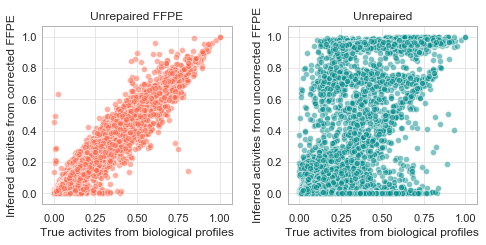

In [45]:
overall_plot(df_sig_activities_unrepaired,"Unrepaired")

**For repaired FFPE**

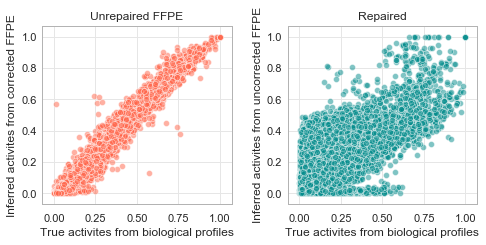

In [46]:
overall_plot(df_sig_activities_repaired,"Repaired")

## 3.3 Quantifying the goodness-of-fit for inferred signature activities

We measure the error of inferred activity proportions to the true values. We then compare whether the errors in corrected is greater than uncorrected FFPE profiles using one-sided wilcoxon test.

**Processing the data**

Add aetiology annotation to all signatures
+ For signatures with known aetiology we keep all of them
+ For signatures without known aetiology we annotate them using original SBS ID. We considered signature with n>20 samples.

In [47]:
def aetiology_annotation_and_preprocessing (data_tmp = df_sig_activities_unrepaired.copy()):

    data_tmp_aetiology = pd.DataFrame()
    ## annotate aetiology if the signatures have it.
    for aetiology in aetiology_list:
        aetiology_sig = sig_aetiology_dict.get(aetiology)
        aetiology_sig_ind = [sig in aetiology_sig for sig in 
                             data_tmp.Signatures]
        aetiology_sig_df = data_tmp.loc[aetiology_sig_ind,:].copy()
        aetiology_sig_df["aetiology"] = aetiology
        data_tmp_aetiology = pd.concat((data_tmp_aetiology, aetiology_sig_df))

    aetiology_sigs = data_tmp_aetiology['Signatures'].unique()

    ## Annotate "Others" to signatures without assigned aetiolog.

    other_sig_ind = [sig not in aetiology_sigs for sig in data_tmp.Signatures]
    other_sig_df = data_tmp.loc[other_sig_ind, :].copy()
    other_sig_df["aetiology"] = other_sig_df["Signatures"].values

    main_other_sigs = other_sig_df.groupby('aetiology').count().index[other_sig_df.groupby('Signatures').count()[
                                                                                            'Samples']>20]
    main_other_sigs_ind = [sig in main_other_sigs for sig in other_sig_df.Signatures]
    mainsig_df = other_sig_df.loc[main_other_sigs_ind,:].copy()

    data_aetiology_mainsig = pd.concat((data_tmp_aetiology, mainsig_df))

    
    aetiology_sigs_order = data_tmp_aetiology.groupby ("aetiology").mean().sort_values("error_of_uncorrected", 
                                                                                ascending = False).index.values

    other_main_sigs_order = mainsig_df.groupby ("aetiology").mean().sort_values("error_of_uncorrected", 
                                                                            ascending = False).index.values
    present_sig_order = list(aetiology_sigs_order) + list(other_main_sigs_order)
    width_of_patch = len(aetiology_sigs_order)/len(present_sig_order)
    
    xticks_text = []
    for sig_label in present_sig_order:
        if " " in sig_label:
            sig_label_new = sig_label.replace(" ", "\n")
    
            xticks_text.append(sig_label_new)
        else:
            xticks_text.append(sig_label)

    stats_present_sig_order = []
    max_error_present_sig_order = []

    for aetiology_tmp in present_sig_order:
        error_uncorrected = data_aetiology_mainsig['error_of_uncorrected'][data_aetiology_mainsig.aetiology == aetiology_tmp].values
        error_corrected =  data_aetiology_mainsig['error_of_corrected'][data_aetiology_mainsig.aetiology == aetiology_tmp].values

        r, p_epsilon = wilcoxon (error_corrected, error_uncorrected, alternative = "less")
        if p_epsilon < 0.001:
            p_label = "***"
        elif p_epsilon < 0.01 and p_epsilon > 0.001:
            p_label = "**"
        elif p_epsilon < 0.05 and p_epsilon > 0.01:
            p_label = "*"
        else:
            p_label = "ns"
    
        stats_present_sig_order.append(p_label)
        max_error_present_sig_order.append(np.mean(error_uncorrected) + 0.05)

    return (data_aetiology_mainsig, xticks_text, present_sig_order, width_of_patch,
            stats_present_sig_order,max_error_present_sig_order)

In [48]:
def scatterplot_main_fig3(data_tmp, aetiologies, name, file=False):
    data_aetiology_mainsig_melted = pd.melt(data_tmp, 
                                            id_vars = ['Samples','Signatures',"True_activities","aetiology"], 
                                            value_vars = ["Uncorrected", "Corrected"])

    f, axs = plt.subplots(1,4, figsize = (8,1.6), gridspec_kw={ 'wspace': 0.26})
    sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 1, 'grid.color': '.9', 
                                                 'ytick.major.size': 2,'axes.edgecolor': '.7'})

    for i, aetiology in enumerate(aetiologies):

        ax = axs[i]
        df_tmp = data_aetiology_mainsig_melted.loc[
                                                data_aetiology_mainsig_melted['aetiology'] == aetiology]
    
        sns.scatterplot(x = "True_activities", y = "value", hue = "variable", 
                        data = df_tmp, palette= {"Corrected":"tomato", "Uncorrected":"darkcyan"}, 
                        s = 25, alpha = 0.5,
                        style = "variable",markers=[ "v", "o"], ax = ax)

        if i > 0:
            t = aetiology + "\n(" + ", ".join(sig_aetiology_dict[aetiology]) + ")"
            ax.set_title(t, size = 11, color = "black",
                     bbox=dict(facecolor='silver', edgecolor='w', alpha = 0.4))
        else:
            ax.set_title("All signatures", size = 11, color = "black",
                     bbox=dict(facecolor='silver', edgecolor='w', alpha = 0.4))    
        if i == 0 :
            ax.set_ylabel("Inferred activity proportion", fontsize = 11, color = "black")
        else:
            ax.set_ylabel("")
        
        upper_limit = np.max(df_tmp.loc[:,[ "True_activities","value"]].values) * 1.5
        ax.set_xlim (-0.05, upper_limit)
        ax.set_ylim (-0.05, upper_limit)
    
        ax.tick_params(axis='both', which='major', labelsize = 9, color = "black")
        ax.plot([0, 1], [0, 1], transform = ax.transAxes, ls = "--", c = "black", alpha = 0.7)
        print (aetiology) 
        for tag in ["Uncorrected", "Corrected"]:
            x = df_tmp.loc[df_tmp["variable"] == tag]['True_activities'].values
            y = df_tmp.loc[df_tmp["variable"] == tag]['value'].values
            r, p = stats.pearsonr(x, y)
        
            print ("\t", tag, "(correlation):", r)
            if (tag == "Uncorrected"):
            
                contribution_change_uncorrected = np.absolute(x-y)
                e = np.mean(contribution_change_uncorrected)
                ax.annotate(f"ε = {e:.2f}", xy=(.1, .88),  xycoords = ax.transAxes, 
                            color = "darkcyan", size = 12)
            if (tag == "Corrected"):

                contribution_change_corrected = np.absolute(x-y)
                e = np.mean(contribution_change_corrected)
                ax.annotate(f"ε = {e:.2f}", xy=(.1, .75), xycoords = ax.transAxes,
                        color = "tomato", size = 12)
        ax.set_xlabel("True activity proportion",fontsize = 11, color = "black")
        if i == 2:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend("", frameon = False)
        else:
            ax.legend("", frameon = False)
        if i == 3:
            ## Plot the label on right side
            left, width,  bottom, height = 1.003, 0.15, 0, 1
            right = left + width
            top = bottom + height
            ax = plt.gca()
            p = plt.Rectangle((left, bottom), width, height, fill=True, color = "silver",alpha = 0.4)
            p.set_transform(ax.transAxes)
            p.set_clip_on(False)
            ax.add_patch(p)
    
            ax.text(0.51 * (left + right), 0.5 * (bottom + top), name, color = 'black',size = 11,
                    horizontalalignment='center',verticalalignment='center',
                    transform=ax.transAxes , rotation = 90)
    
    axs[1].legend(handles = handles[1:] , labels=labels[1:],loc='upper center', 
                 bbox_to_anchor = (0.5, -0.4), shadow=False, ncol=2, frameon = False)
    if file:
        plt.savefig(file, bbox_inches = "tight", dpi = 300)
    plt.show()

In [49]:
def scatterplot_supp_fig7(data, other_aetiologie, name = "Unrepaired", file = False):
    
    
    data_aetiology_mainsig_melted = pd.melt(data, 
                                            id_vars = ['Samples','Signatures',"True_activities","aetiology"], 
                                            value_vars = ["Uncorrected", "Corrected"])
    
    sns.set(style="whitegrid", color_codes=True,
            rc={"grid.linewidth": 1, 'grid.color': '.9', 
            'ytick.major.size': 2,'axes.edgecolor': '.7'})

    nrow, ncol = 3, 6
    f, axs = plt.subplots(nrow,ncol, figsize = (12,6), gridspec_kw={ 'wspace': 0.3, 'hspace' : 0.6})
    
    fig_ind = []
    for i in range(nrow):
        for j in range(ncol):
            fig_ind.append((i,j))
    n = 0
    
    for i, sig in enumerate(other_aetiologies):

        ax = axs[fig_ind[n]]
        n += 1
        df_tmp = data_aetiology_mainsig_melted.loc[data_aetiology_mainsig_melted['aetiology'] == sig]
    
        sns.scatterplot(x = "True_activities", y = "value", hue = "variable", 
                        data = df_tmp, palette= {"Corrected":"tomato", "Uncorrected":"darkcyan"}, 
                        s = 25, alpha = 0.5,
                        style = "variable", markers=[ "v", "o"], ax = ax)
        t = sig
        ax.set_title(t, size = 12, color = "black",
                     bbox=dict(facecolor='silver', edgecolor='w', alpha = 0.4))
        if n > 12:
            ax.set_xlabel("True activity\nproportions",fontsize = 11, color = "black")
        else:
            ax.set_xlabel("")
    
        if n == 1 or n == 7 or n == 13:
            ax.set_ylabel("Inferred activity\nproportions", fontsize = 11, color = "black")
        else:
            ax.set_ylabel("")
        
        upper_limit = np.max(df_tmp.loc[:,[ "True_activities","value"]].values) * 1.5
        ax.set_xlim (-0.05, upper_limit)
        ax.set_ylim (-0.05, upper_limit)
    
        ax.plot([0, 1], [0, 1], transform = ax.transAxes, ls = "--", c = "black", alpha = 0.7)
    
        for tag in ["Uncorrected", "Corrected"]:
            x = df_tmp.loc[df_tmp["variable"] == tag]['True_activities'].values
            y = df_tmp.loc[df_tmp["variable"] == tag]['value'].values
        
            r, p = stats.pearsonr(x, y)
            if (tag == "Uncorrected"):
                contribution_change_uncorrected = np.absolute(x-y)
                e = np.mean(contribution_change_uncorrected)
                ax.annotate(f"ε = {e:.2f}", xy=(.1, .88),  xycoords = ax.transAxes, 
                            color = "darkcyan", size = 12)
            if (tag == "Corrected"):
                contribution_change_corrected = np.absolute(x-y)
                e = np.mean(contribution_change_corrected)
                ax.annotate(f"ε = {e:.2f}", xy=(.1, .75), xycoords = ax.transAxes,
                            color = "tomato", size = 12)
            
        if n == 18:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend("", frameon = False)
        else:
            ax.legend("", frameon = False)
        
    axs[fig_ind[14]].legend(handles = handles[1:] , labels=labels[1:],loc='upper center', 
                 bbox_to_anchor = (0.5, -0.6), shadow=False, ncol=2, frameon = False)
    
    plt.suptitle (name, size = 13)
    if file:
        plt.savefig(file, bbox_inches = "tight", dpi = 300)
    plt.show()

In [50]:
def bar_plot_main_fig3(data_tmp, present_sig_order,stats_present_sig_order, max_error_present_sig_order,
                      width_of_patch, ylim_max = .5, pos = 4, file = False, tag = "Unrepaired"):
    data_aetiology_mainsig_melted = pd.melt(data_tmp, 
                                            id_vars = ['Samples','Signatures',"True_activities","aetiology"], 
                                            value_vars = ["error_of_uncorrected", "error_of_corrected"])
    sns.catplot(x="aetiology", y="value", hue="variable", 
                data = data_aetiology_mainsig_melted,  height=2, aspect= 5,
                palette=['darkcyan','tomato'], order = present_sig_order,
                legend = None, kind = "bar", alpha = 0.8)

    ## adding stats
    length = len(stats_present_sig_order)
    for i in range(length):
        ## bottom pannel color bars 
        left, width = 0 + 1/length * i + 0.001, 1/length - 0.002        
        bottom, height = 1.12, 0.10
        right = left + width
        top = bottom + height
        ax = plt.gca()
        if stats_present_sig_order[i] == "ns":
            ax.text(0.5 * (left + right), max_error_present_sig_order[i] * pos, stats_present_sig_order[i], 
                color = "dimgrey", size = 13,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
        else:
            ax.text(0.5 * (left + right), max_error_present_sig_order[i] * pos, stats_present_sig_order[i], 
                color = "dimgrey", size = 15,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

    ## adding subtitles
    patch_width = width_of_patch

    left, width,  bottom, height = 0, patch_width, 1.1, 0.2
    right = left + width
    top = bottom + height
    ax = plt.gca()
    p = plt.Rectangle((left, bottom), width, height, fill=True, color = "dimgrey",alpha = 0.3)
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(0.5 * (left + right), 0.5 * (bottom + top), "Signatures with known aetiology", 
            color = 'black',size = 12,
            horizontalalignment='center',verticalalignment='center',transform=ax.transAxes)

    left, width,  bottom, height = patch_width, (1-patch_width), 1.1, 0.2
    right = left + width
    top = bottom + height
    ax = plt.gca()
    p = plt.Rectangle((left, bottom), width, height, fill=True, color = "dimgrey",alpha = 0.1)
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    ax.text(0.5 * (left + right), 0.5 * (bottom + top), "Signatures without known aetiology", 
            color = 'black',size = 12,
            horizontalalignment='center',verticalalignment='center',transform=ax.transAxes)
    
    ##### adding tag
    
    left, width,  bottom, height = 1.003, 0.02, 0, 1.1
    right = left + width
    top = bottom + height
    ax = plt.gca()
    p = plt.Rectangle((left, bottom), width, height, fill=True, color = "silver",alpha = 0.5)
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    
    ax.text(0.5 * (left + right), 0.5 * (bottom + top), tag, color = 'black',size = 11,
                    horizontalalignment='center',verticalalignment='center',
                    transform=ax.transAxes , rotation = 90)
    ## legend
    handles, labels = ax.get_legend_handles_labels()    
    plt.legend(handles, ["Uncorrected", "Corrected"], bbox_to_anchor=(1.02, 1),
            frameon = False)

    plt.xticks (range(len(xticks_text)), xticks_text, rotation = 90, size = 11, 
            horizontalalignment='center')
    plt.xlabel("")
    plt.ylim(0, ylim_max)
    plt.ylabel("Error in\ninferred signature activity")
    if file:
        plt.savefig (file, bbox_inches = "tight", dpi = 300)
    plt.show()

In [51]:
def boxenplot_main_fig3(data, name = "Unrepaired", file = False):
    reconstruction_accuracy_melted = pd.melt(data,
                                                  value_vars = ["Biological",
                                                                "Corrected",
                                                                "Uncorrected"])
    f, ax = plt.subplots(figsize = (2.5,2.2))
    sns.boxenplot(x = "variable", y = "value", data = reconstruction_accuracy_melted,
                   hue = "variable", palette= {"Corrected":"tomato",
                                          "Uncorrected" : "darkcyan",
                                          "Biological":"grey"}, ax = ax)
    
    ## adding pvalue
    t, p2 = wilcoxon(data['Uncorrected'].values, data['Corrected'].values) ## difference test
    
    x1, x2 = 1.05, 2.3
    y, h, col = reconstruction_accuracy_melted['value'].max()+0.05, 0.02, 'black' 
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c = col)
    ax.text((x1 + x2) * .5, y + h + 0.03, 'p={0:1.1e}'.format(p2), ha='center', 
            va='bottom', color=col, size = 10)

    ##### adding name    
    left, width,  bottom, height = 0, 1, 1.03, 0.13
    right = left + width
    top = bottom + height
    ax = plt.gca()
    p = plt.Rectangle((left, bottom), width, height, fill=True, color = "silver",alpha = 0.5)
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)    
    ax.text(0.5 * (left + right), 0.5 * (bottom + top), name, color = 'black',size = 11,
            horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    
    ## legend
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(loc = "lower left",handles = handles,
               labels = labels, frameon = False, fontsize = 11)
    ## labels
    plt.xticks([])
    plt.xlabel("Mutational profile\nused for signature refitting", color = 'black', size = 11)
    plt.ylabel("Reconstruction accuracy\nto true profiles", 
           color = 'black', size = 11)
    plt.ylim(0.2,1.2)
    plt.yticks([0.2, 0.4, 0.6,0.8,1.0],color = 'black', size = 10.5 )
    sns.despine()
    if file:
        plt.savefig(file, bbox_inches = "tight", dpi = 300)
    plt.show()

### Unrepaired FFPE

We rank the the sigantures using mean of error from uncorrected profiles. But the rank is done seperately for signatures with known aetiology and without known aetiology.

In [52]:
data_aetiology_mainsig, xticks_text, present_sig_order, width_of_patch, stats_present_sig_order,max_error_present_sig_order = aetiology_annotation_and_preprocessing(df_sig_activities_unrepaired.copy())
stats_of_unrepaired_FFPE = data_aetiology_mainsig.groupby ("aetiology").mean().loc[present_sig_order,:]
stats_of_unrepaired_FFPE['sample_size'] = data_aetiology_mainsig.groupby ("aetiology").count().loc[present_sig_order,
                                                                                                   :]['Samples'].values
stats_of_unrepaired_FFPE['labels'] = stats_present_sig_order
stats_of_unrepaired_FFPE

,True_activities,Uncorrected,Corrected,error_of_uncorrected,error_of_corrected,sample_size,labels
aetiology,,,,,,,
HR deficiency,0.404033,0.044681,0.501981,0.359352,0.104036,188,***
BER deficiency,0.147722,0.416377,0.102436,0.351167,0.057372,31,***
Treatment exposure,0.302756,0.212947,0.328410,0.163621,0.053901,12,**
ROS damage,0.176441,0.027934,0.205677,0.148507,0.032691,373,***
Tobacco,0.281946,0.155313,0.336301,0.126633,0.054355,162,***
Mutagen exposure,0.241373,0.118114,0.271119,0.123259,0.029747,19,***
Clock-like,0.127188,0.052116,0.138646,0.075990,0.013145,1559,***
APOBEC,0.094418,0.113286,0.094033,0.075120,0.015448,1194,***
MMR deficiency,0.290127,0.261510,0.307227,0.064878,0.035999,67,***


In [53]:
stats_of_unrepaired_FFPE.shape

(21, 7)

#### 3.3.1.1 Scatterplot of true vs inferred signature activities
+ all signatures
+ a few selected signatures with known aetiology

We will show scatterplot of inference for all signatures and the few signatures (with known aetiology) as an example

all signatures
	 Uncorrected (correlation): 0.5772577327241661
	 Corrected (correlation): 0.9604394108187835
HR deficiency
	 Uncorrected (correlation): 0.5704475807227501
	 Corrected (correlation): 0.9208514851939993
BER deficiency
	 Uncorrected (correlation): 0.3193792386145803
	 Corrected (correlation): 0.9447179718318427
ROS damage
	 Uncorrected (correlation): 0.6194530174010879
	 Corrected (correlation): 0.966684564986563


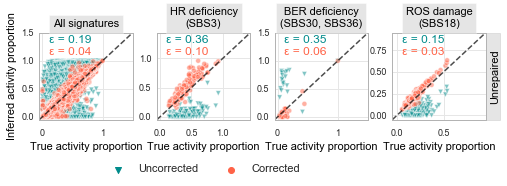

In [54]:
df_sig_activities_unrepaired_copy = df_sig_activities_unrepaired.copy()
df_sig_activities_unrepaired_copy['aetiology'] = "all signatures"
all_sig_aetiology_mainsig_df = pd.concat((df_sig_activities_unrepaired_copy, data_aetiology_mainsig))
unrepaired_main_aetiologies = ['all signatures', 'HR deficiency',  'BER deficiency', 'ROS damage']
scatterplot_main_fig3(all_sig_aetiology_mainsig_df, 
                      aetiologies = unrepaired_main_aetiologies,
                      name = "Unrepaired", file = "./Figures/Fig3a.pdf")

#### 3.3.1.2 Barplot of errors of inferred signature activities

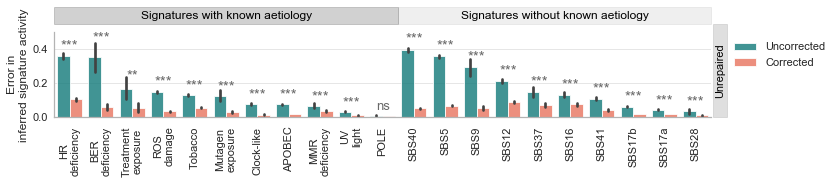

In [55]:
max_error_present_sig_order[1] = max_error_present_sig_order[1] + 0.05
max_error_present_sig_order[2] = max_error_present_sig_order[2] + 0.02
bar_plot_main_fig3(data_aetiology_mainsig, present_sig_order,stats_present_sig_order, 
                   max_error_present_sig_order, width_of_patch, ylim_max = .5, pos = 2.05,
                   tag = "Unrepaired", file = "./Figures/Fig3c.pdf")

#### 3.3.1.3 Scatterplot of ture vs inferred signature activities
+ remaining signatures with known aetiology
+ remaining signatures without known aetiology

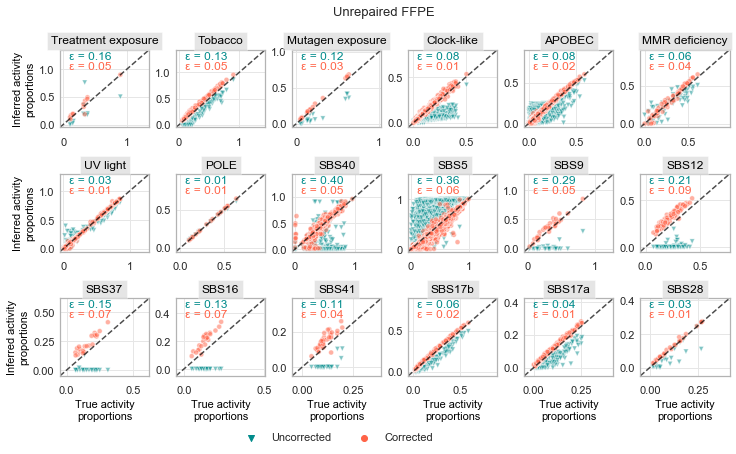

In [56]:
other_aetiologies = stats_of_unrepaired_FFPE.index.values[[i not in unrepaired_main_aetiologies for
                                       i in stats_of_unrepaired_FFPE.index.values]]
scatterplot_supp_fig7(data_aetiology_mainsig, other_aetiologies, 
                      "Unrepaired FFPE", "./Figures/SFig7a.pdf")

In [59]:
## False_positives; false negatives:
FN_ind = []
FP_ind = []
for i in range(data_aetiology_mainsig.shape[0]):
#    print (i)
    ind = data_aetiology_mainsig["True_activities"].values[i] > 0.2 and data_aetiology_mainsig["Corrected"].values[i]<0.05
    FN_ind.append(ind)
    
    ind = data_aetiology_mainsig["True_activities"].values[i] < 0.05 and data_aetiology_mainsig["Corrected"].values[i]>0.2
    FP_ind.append(ind)
data_aetiology_mainsig.loc[FN_ind,'Signatures'].unique(), data_aetiology_mainsig.loc[FP_ind,'Signatures'].unique()

(array(['SBS5', 'SBS40'], dtype=object), array(['SBS40'], dtype=object))

In [60]:
sum(FN_ind), sum(FP_ind), sum(FN_ind)+ sum(FP_ind), (sum(FN_ind)+ sum(FP_ind)) / len(FN_ind)

(27, 7, 34, 0.004899135446685879)

#### 3.3.1.4 Reconstruction accuracy of corrected vs uncorrected profiles

In [61]:
reconstruction_accuracy_unrepaired = pd.DataFrame(
    {"Biological": reconstruction_accuracy_unrepaired_biological,
    "Corrected" : reconstruction_accuracy_unreparied_corrected,
    "Uncorrected": reconstruction_accuracy_unreparied_uncorrected})

reconstruction_accuracy_unrepaired.describe()

,Biological,Corrected,Uncorrected
count,1680.000000,1680.000000,1680.000000
mean,0.971268,0.967381,0.863784
std,0.017631,0.018487,0.079418
min,0.873896,0.874320,0.560565
25%,0.963339,0.958602,0.812601
50%,0.973807,0.969023,0.864607
75%,0.981867,0.978703,0.922840
max,0.999686,0.999659,0.999497


In [62]:
reconstruction_accuracy_unrepaired.apply(CI)

Biological     (0.9704238595555759, 0.9721112846459277)
Corrected      (0.9664967037596185, 0.9682660530463935)
Uncorrected    (0.8599840582406156, 0.8675848066089128)
dtype: object

In [63]:
# normality test
for col in reconstruction_accuracy_unrepaired.columns:
    data = reconstruction_accuracy_unrepaired['Corrected'].values
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print(f'{col}\nlooks Gaussian (fail to reject H0)')
    else:
        print(f'{col}\ndoes not look Gaussian (reject H0)')

Statistics=0.949, p=0.000
Biological
does not look Gaussian (reject H0)
Statistics=0.949, p=0.000
Corrected
does not look Gaussian (reject H0)
Statistics=0.949, p=0.000
Uncorrected
does not look Gaussian (reject H0)


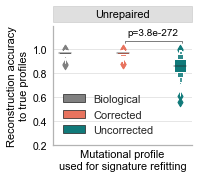

In [64]:
boxenplot_main_fig3(reconstruction_accuracy_unrepaired, name = "Unrepaired", file = "./Figures/Fig3e.pdf")

### 3.3.2 Repaired FFPE

In [65]:
data_aetiology_mainsig, xticks_text, present_sig_order, width_of_patch, stats_present_sig_order,max_error_present_sig_order = aetiology_annotation_and_preprocessing(df_sig_activities_repaired.copy())
stats_of_repaired_FFPE = data_aetiology_mainsig.groupby ("aetiology").mean().loc[present_sig_order,:]
stats_of_repaired_FFPE['sample_size'] = data_aetiology_mainsig.groupby ("aetiology").count().loc[present_sig_order,
                                                                                                   :]['Samples'].values
stats_of_repaired_FFPE['labels'] = stats_present_sig_order
stats_of_repaired_FFPE

,True_activities,Uncorrected,Corrected,error_of_uncorrected,error_of_corrected,sample_size,labels
aetiology,,,,,,,
Clock-like,0.094100,0.328719,0.059785,0.234619,0.041531,1456,***
HR deficiency,0.470448,0.311018,0.530822,0.179100,0.064351,223,***
Treatment exposure,0.278997,0.167153,0.291168,0.111844,0.013725,14,***
Mutagen exposure,0.265488,0.160789,0.276183,0.104698,0.011197,26,***
BER deficiency,0.128489,0.153402,0.127684,0.072647,0.018146,52,***
Tobacco,0.233656,0.180770,0.243800,0.070122,0.012973,285,***
MMR deficiency,0.259908,0.229655,0.286386,0.055855,0.047192,78,ns
ROS damage,0.178828,0.126453,0.198667,0.055099,0.026377,205,***
APOBEC,0.099118,0.062182,0.107738,0.041838,0.010650,1036,***


#### 3.3.2.1 Scatterplot of true vs inferred signature activities
+ all signatures
+ a few selected signatures with known aetiology

all signatures
	 Uncorrected (correlation): 0.6705983216019991
	 Corrected (correlation): 0.9811605824566527
Clock-like
	 Uncorrected (correlation): 0.6691046170280126
	 Corrected (correlation): 0.8865610525198564
HR deficiency
	 Uncorrected (correlation): 0.687668109811835
	 Corrected (correlation): 0.9655173489083866
Mutagen exposure
	 Uncorrected (correlation): 0.9795208449290159
	 Corrected (correlation): 0.9982362075601114


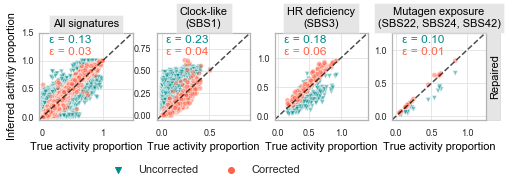

In [66]:
df_sig_activities_repaired_copy = df_sig_activities_repaired.copy()
df_sig_activities_repaired_copy['aetiology'] = "all signatures"

all_sig_aetiology_mainsig_df = pd.concat((df_sig_activities_repaired_copy, data_aetiology_mainsig))
repaired_main_aetiologies = ['all signatures', 'Clock-like','HR deficiency', 'Mutagen exposure']
scatterplot_main_fig3(all_sig_aetiology_mainsig_df, 
                      aetiologies = repaired_main_aetiologies,
                      name = "Repaired", file = "./Figures/Fig3b.pdf")

#### 3.3.2.2 Barplot of errors of inferred signature activities

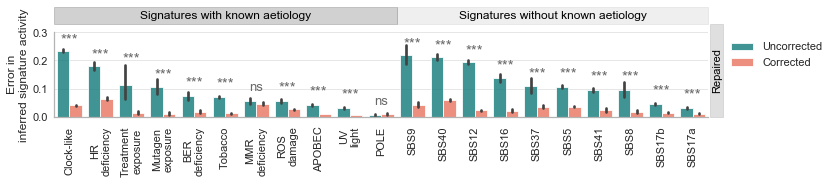

In [67]:
max_error_present_sig_order[2] = max_error_present_sig_order[2] + 0.05
bar_plot_main_fig3(data_aetiology_mainsig, present_sig_order,stats_present_sig_order, 
                   max_error_present_sig_order, width_of_patch, ylim_max = .3, pos = 3.2,
                   tag = "Repaired", file = "./Figures/Fig3d.pdf")

#### 3.3.2.3 Scatterplot of ture vs inferred signature activities
+ remaining signatures with known aetiology
+ remaining signatures without known aetiology

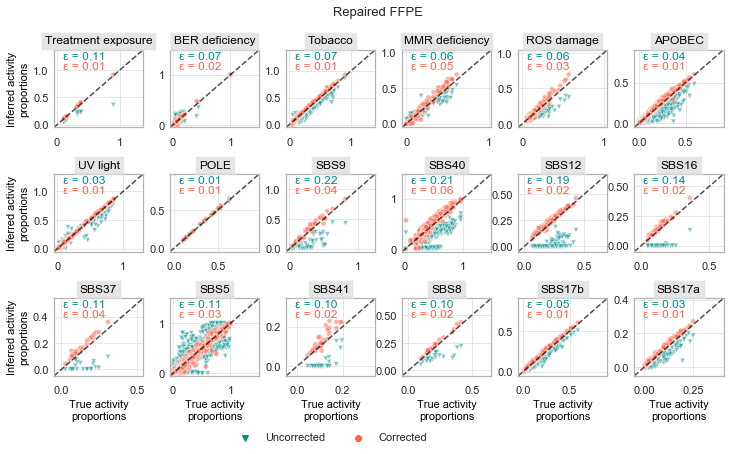

In [68]:
other_aetiologies = stats_of_repaired_FFPE.index.values[[i not in repaired_main_aetiologies for
                                       i in stats_of_repaired_FFPE.index.values]]
scatterplot_supp_fig7(data_aetiology_mainsig, other_aetiologies, "Repaired FFPE",
                      "./Figures/SFig7b.pdf")

In [69]:
## False positives and false negatives:
FN_ind = []
FP_ind = []
for i in range(data_aetiology_mainsig.shape[0]):
#    print (i)
    ind = data_aetiology_mainsig["True_activities"].values[i] > 0.2 and data_aetiology_mainsig["Corrected"].values[i]<0.05
    FN_ind.append(ind)
    
    ind = data_aetiology_mainsig["True_activities"].values[i] < 0.05 and data_aetiology_mainsig["Corrected"].values[i]>0.2
    FP_ind.append(ind)

In [70]:
sum(FP_ind),sum(FN_ind), (sum(FP_ind)+sum(FN_ind))/data_aetiology_mainsig.shape[0]

(1, 6, 0.0010601241859760715)

In [71]:
data_aetiology_mainsig.loc[FN_ind,'Signatures'].unique(), data_aetiology_mainsig.loc[FP_ind,'Signatures'].unique()

(array(['SBS40', 'SBS5'], dtype=object), array(['SBS40'], dtype=object))

#### 3.3.2.4 Reconstruction accuracy of corrected vs uncorrected profiles

In [72]:
reconstruction_accuracy_repaired = pd.DataFrame(
    {"Biological": reconstruction_accuracy_repaired_biological,
     "Corrected" : reconstruction_accuracy_reparied_corrected,
     "Uncorrected": reconstruction_accuracy_reparied_uncorrected})

reconstruction_accuracy_repaired.describe()

,Biological,Corrected,Uncorrected
count,1625.000000,1625.000000,1625.000000
mean,0.969775,0.956910,0.787628
std,0.018953,0.026492,0.145038
min,0.873896,0.810911,0.329789
25%,0.961338,0.942875,0.658199
50%,0.972242,0.961094,0.793221
75%,0.981758,0.974675,0.926452
max,0.999686,0.999669,0.999295


In [73]:
reconstruction_accuracy_repaired.apply(CI)

Biological     (0.9688523287149303, 0.9706967128487133)
Corrected      (0.9556213434316956, 0.9581993848613688)
Uncorrected    (0.7805712480107471, 0.7946854937684268)
dtype: object

In [74]:
# normality test
for col in reconstruction_accuracy_repaired.columns:
    data = reconstruction_accuracy_repaired['Corrected'].values
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print(f'{col}\nlooks Gaussian (fail to reject H0)')
    else:
        print(f'{col}\ndoes not look Gaussian (reject H0)')

Statistics=0.949, p=0.000
Biological
does not look Gaussian (reject H0)
Statistics=0.949, p=0.000
Corrected
does not look Gaussian (reject H0)
Statistics=0.949, p=0.000
Uncorrected
does not look Gaussian (reject H0)


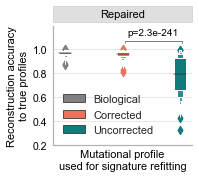

In [75]:
boxenplot_main_fig3(reconstruction_accuracy_repaired, name = "Repaired", 
                    file = "./Figures/Fig3f.pdf")